# 支持向量机（Support Vector Machine）

## 简介

支持向量机的原始算法于1963年由苏联科学家 **弗拉基米尔·万普尼克(Владимир Наумович Вапник)** 等发明，最初发表于俄文期刊 **自动化与远程控制 (АВТОМАТИКА И ТЕЛЕМЕХАНИКА)**. 

点击 [Узнавание образов при помощи обобщенных портретов](http://www.mathnet.ru/links/15c09987c4667b628d040141610ef1b6/at11885.pdf) 查看原始俄语论文，也可以查看英语翻译版 [Recognition of Patterns with help of Generalized Portraits](http://web.cs.iastate.edu/~cs573x/vapnik-portraits1963.pdf)(这个链接可能打不开了)

直到1990年代，由于核技巧(kernel trick)的引入，使得SVM有了非线性的分类能力，SVM才开始获得成功，并引起了一次人工智能的高潮。

在这次作业中，你们需要实现:
- 最基本的线性支持向量机
- 梯度下降的优化算法
- 序列最小优化(SMO)算法和核技巧
- 学会使用scikit-learn中的SVM

并回答一些相关问题

**本次小作业截止时间：5.7, 请在canvas系统中及时提交。**

## 线性 SVM 分类器与梯度下降

在这一部分中，你们需要实现最基本的线性SVM分类器，并完成一个二分类问题，首先我们需要制造一点数据。运行下面的代码就可以得到一个简单的数据集。

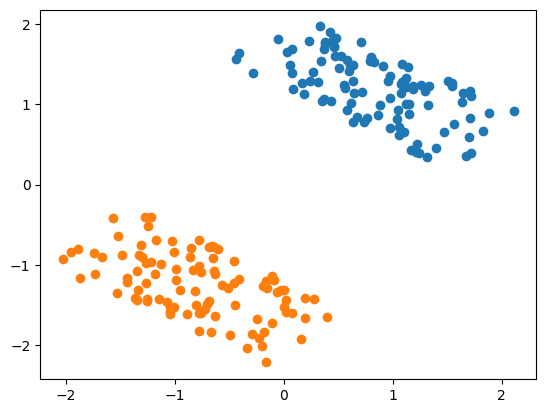

In [12]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1024)

def data_visualization(x, y, pdim=2):
    category = {'+1': [], '-1': []}
    for point, label in zip(x, y):
        if label == 1.0: category['+1'].append(point)
        else: category['-1'].append(point)
    fig = plt.figure()
    if pdim == 2 or pdim == 1:
        ax = fig.add_subplot(111)
    elif pdim == 3:
        ax = fig.add_subplot(111, projection='3d')

    for label, pts in category.items():
        pts = np.array(pts)
        if pdim == 1:
            ax.scatter(pts[:, 0], label=label)
        elif pdim == 2:
            ax.scatter(pts[:, 0], pts[:, 1], label=label)
        elif pdim == 3:
            if label == '+1':
                c = 'blue'
                m = 'o'
            else:
                c = 'black'
                m = 'x'
            ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=c, marker=m)
    plt.show() 


# random a dataset on 2D plane
def simple_synthetic_data(n, n0=5, n1=5): # n: number of points, n0 & n1: number of points on boundary
    # random a line on the plane
    w = np.random.rand(2) 
    w = w / np.sqrt(w.dot(w))
    
    # random n points 
    x = np.random.rand(n, 2) * 2 - 1
    d = (np.random.rand(n) + 1) * np.random.choice([-1,1],n,replace=True) # random distance from point to the decision line, d in [-2,-1] or [1,2]. d=-1 or d=1 indicate the boundary in svm
    d[:n0] = -1
    d[n0:n0+n1] = 1
    
    # shift x[i] to make the distance between x[i] and the decision become d[i]
    x = x - x.dot(w).reshape(-1,1) * w.reshape(1,2) + d.reshape(-1,1) * w.reshape(1,2)
    
    # create labels
    y = np.zeros(n)
    y[d < 0] = -1
    y[d >= 0] = 1
    return x, y

x_data, y_data = simple_synthetic_data(200)
data_visualization(x_data, y_data)

### 线性SVM

对于上文生成的这组二分类数据，在课堂上，我们首先引入间隔函数: 

$$
\hat{\gamma}^{(i)}=y^{(i)}(\boldsymbol{w^\top}\boldsymbol{x}^{(i)} + b)
$$

其中，$\boldsymbol{w}$为分界(超)平面的一个法向量，$\boldsymbol{x}^{(i)}$ 为第$i$个样本，$\boldsymbol{y}^{(i)}$ 为第$i$个样本的标签，我们很容易看出$\boldsymbol{w^\top}\boldsymbol{x}^{(i)} + b$类似于一个 **没有取绝对值的点到平面的距离公式** ，$\boldsymbol{y}^{(i)}$则指示了在分界平面之上或者之下，即样本点的类别。我们希望**所有点到分类边界的距离越远越好**，此外，在运算中，将法向量归一化是一个很合理的想法，于是，问题转化为

$$
\begin{aligned}
 & \max_{\gamma,\boldsymbol{w},b} \gamma \\\\
\mathrm{s.t.}\quad & y^{(i)}(\boldsymbol{w}^\top \boldsymbol{x}^{(i)} + b) \ge {\gamma},\quad i=1..,m\\
 & \|\boldsymbol{w}\|_2 = 1
\end{aligned}
$$

其中$\gamma = \min\{\hat{\gamma}^{(1)}, \hat{\gamma}^{(1)}, \hat{\gamma}^{(1)}, \cdots, \hat{\gamma}^{(n)}\}$，这个问题等价于

$$
\begin{aligned}
 & \max_{\gamma,\boldsymbol{w},b} \frac{\gamma}{\|\boldsymbol{w}\|_2} \\\\
\mathrm{s.t.}\quad & y^{(i)}(\boldsymbol{w}^\top \boldsymbol{x}^{(i)} + b) \ge {\gamma},\quad i=1..,m\\
\end{aligned}
$$

我们可以规定数据点最小的距离为1，则

$$
\begin{aligned}
 & \max_{\boldsymbol{w},b} \frac{1}{\|\boldsymbol{w}\|_2} \equiv \min_{\boldsymbol{w},b} \frac{1}{2}\|\boldsymbol{w}\|_2^2\\\\
\mathrm{s.t.}\quad & y^{(i)}(\boldsymbol{w}^\top \boldsymbol{x}^{(i)} + b) \ge 1,\quad i=1..,m\\
\end{aligned}
$$


这样一来，我们就把这个问题从一个关于$\gamma,w,b$非凸优化转化为一个关于$w, b$的凸优化。

所以我们可以通过之前讲过的梯度下降方法来求解这个问题，即优化一个损失函数。我们在课上学习了Hinge Loss，对于一组数据，可以写成

$$
{\cal{L}}_{\mathrm{SVM}} = C\|\boldsymbol{w}\|_2^2 + \sum_{i=1}^{N}\max(0, 1 - y_i(\boldsymbol{w}^\top \boldsymbol{x}^{(i)} + b))
$$

其中 $C$ 为可调节的常数，作为 L2 正则化系数

下面请回答这样几个问题，请使用markdown语法直接在题目下方作答：

#### Question1：
为什么最小化Hinge Loss等价于优化上面关于$\boldsymbol{w},b$的优化问题？（提示：不必严格证明，只需简单合理的说明）
#### Answer:
对于Hinge Loss函数，如果样本预测正确，那么后项值为0，不影响损失函数，如果后项预测错误，则后项不为0，且大于0，就会使得损失函数变大，且距离间隔越远，损失越大。因此最小化损失函数就是优化参数$\boldsymbol{w},b$，使得错误的样本尽可能少。
 
#### Question2：
证明 $f(\boldsymbol{w}, b) = C\|\boldsymbol{w}\|_2^2 + \max(0, 1 - y(\boldsymbol{w}^\top \boldsymbol{x} + b))$ 是凸函数（提示：请复习凸函数的定义，你可以利用任何在先修课程中学过的性质、方法和技巧来证明，比如可以通过函数复合的性质来证明，合理即可）
#### Answer:
凸函数之和依然为凸函数，首先前者是一个二次函数，显然为凸函数。

后者在预测正确的点上面是不连续的，导数不存在，但在预测错误的地方为凸函数，因此后者是一个有部分不连续点的凸函数

因此二者之和依然为凸函数

#### Question3：
对于一个凸函数 $f(\boldsymbol{x})$，假设我们找到了一个局部最优解 $\boldsymbol{x_0}$，证明这个最优解是全局最优解。（提示：凸函数定义）
#### Answer:
假设一个凸函数的局部最优解不是全局最优解，则其一定存在多个局部最优解，且它门互不相同。则考虑其中两个相邻的局部最优解。

因为二者均为局部最优解，所以两个点的一阶导数均等于0， 则两个点之间的一阶导数一定是先升后降或先降后升，则两个点之间的二阶导数一定异号，与凸函数的定义矛盾，所以局部最优解一定是全局最优解


如果你成功回答了上面的问题，你就可以理解我们可以通过梯度下降的方式找到SVM的最优解，下面就需要实现基本的SVM以及梯度下降

In [13]:
def svm_sgd(w, b, X_in, y_in, reg):
    """
    Inputs have dimension D, we operate on minibatches of N examples.
    - w: The weight, a numpy array of shape (D,) containing weights 
    - b: The bias, a constant 
    - X_in: A numpy array of shape (N, D) containing a minibatch of data.
    - y_in: A numpy array of shape (N,) containing training labels; y[i] = -1/ 1 means that X[i] has label -1/1
    - reg: regularization factor, constant, float

    Returns a tuple of:
    - loss, loss as single float
    - dw, gradient with respect to weights W; an array of same shape as W
    - db, gradient with respect to bias b, a constant
    """
    loss = 0.0
    dw = np.zeros(w.shape)
    db = 0.0
    #############################################################################
    # TODO:                                                                     #
    # Implement SVM loss, storing the result in loss.                           #
    # **No explicit loop allowed, otherwise your points will be deducted**      #
    #############################################################################
    
    temp = np.maximum(0, 1 - y_in * (np.dot(X_in, w) + b))
    loss = temp.sum() + reg * np.sum(w * w)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    
    #############################################################################
    # TODO:                                                                     #
    # Implement SVM gradient respect to w and b,                                #
    # storing the result in dw, db, respectively.                               #
    # **No explicit loop allowed, otherwise your points will be deducted**      #
    # **Always assume that the loss function is differentiable**                #
    #############################################################################
    
    tmp = np.where(temp > 0, -y_in, 0)
    dw = 2 * reg * w + tmp @ X_in
    db = tmp.sum()
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dw, db

到这里你们已经完成了基本的线性SVM，及其梯度计算，下面的一些代码可以用于检查调试你的代码

In [14]:
from random import randrange, seed

seed(1024)
def check_gradient_simple():
    """
    This function check gradient using numerical method, formally:
    \frac{\partial f}{\partial w_i} = (f(w_i + h) - f(w_i - h)) / 2h
    The relative error should be very small
    """
    reg = 0.5
    for i in range(10):
        w = np.random.randn(2) 
        b = np.random.randn(1)
        loss, dw, db = svm_sgd(w, b, x_data, y_data, reg)
        h = 1e-5
        idx = randrange(2)
        
        wp = w.copy()
        wp[idx] += h
        
        wm = w.copy()
        wm[idx] -= h
        
        evalwp, _, _ = svm_sgd(wp, b, x_data, y_data, reg)
        evalwm, _, _ = svm_sgd(wm, b, x_data, y_data, reg)
        
        grad_num_w = (evalwp - evalwm) / (2 * h)
        
        bp = b + h
        bm = b - h
        evalbp, _, _ = svm_sgd(w, bp, x_data, y_data, reg)
        evalbm, _, _ = svm_sgd(w, bm, x_data, y_data, reg)
        grad_num_b = (evalbp - evalbm) / (2 * h)
        
        rel_dw_error = np.abs(dw[idx] - grad_num_w) / (np.abs(dw[idx]) + np.abs(grad_num_w))
        rel_db_error = np.abs(db - grad_num_b) / (np.abs(db) + np.abs(grad_num_b))
        
        print('#%d randomly calculate svm loss: %f, relative dw error: %.12f, relative db error: %.12f'
              % (i, loss, rel_dw_error, rel_db_error))
        
check_gradient_simple()

#0 randomly calculate svm loss: 471.131854, relative dw error: 0.000000000014, relative db error: 0.000000000034
#1 randomly calculate svm loss: 107.250652, relative dw error: 0.000000000000, relative db error: 0.000000000003
#2 randomly calculate svm loss: 181.484498, relative dw error: 0.000000000000, relative db error: 0.000000000159
#3 randomly calculate svm loss: 165.535571, relative dw error: 0.000000000007, relative db error: 0.000000000026
#4 randomly calculate svm loss: 275.981695, relative dw error: 0.000000000006, relative db error: 0.000000000159
#5 randomly calculate svm loss: 208.929869, relative dw error: 0.000000000001, relative db error: 0.000000000001
#6 randomly calculate svm loss: 156.859857, relative dw error: 0.000000000001, relative db error: 0.000000000019
#7 randomly calculate svm loss: 259.135887, relative dw error: 0.000000000005, relative db error: 0.000000000023
#8 randomly calculate svm loss: 166.532270, relative dw error: 0.000000000007, relative db error

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
C:\Users\xun_y\AppData\Local\Temp\ipykernel_19856\2903547463.py:5: SyntaxWarning: invalid escape sequence '\p'
  """


如果你的相对误差大多数量级在 $10^{-10}$ 及以下，说明你通过了梯度检查，说明你的代码实现正确。然后请你回答以下问题：

#### Question4：
在计算梯度时，我们假设函数可微，但事实上并非如此，如果你运行梯度检查足够多次，你会发现梯度检查可能失败，请说明在何种情况下我们无法计算梯度（简要说明，无需严格证明，合理即可）

#### Answer：
当预测正确的点足够多时，Hinge Loss函数变得不连续，也就不再可微


回答问题之后，就可以开始训练简单的线性SVM分类器了

In [15]:
def train_svm_sgd(w, b, num_epoch, lr=5e-3, reg=0.0):
    """
    Implement SVM SGD training algorithm here, we randomly initilaize the weight and bias
    """
    
    for e in range(num_epoch):
        loss, dw, db = svm_sgd(w, b, x_data, y_data, reg)
        print('epoch %d, the loss is %f' % (e+1, loss))
    #############################################################################
    # TODO:                                                                     #
    # Implement Gradient Descent with learning decay to train SVM               #
    #############################################################################
    
        w -= lr * dw
        b -= lr * db
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return w, b
    
w = np.random.randn(2)
b = np.random.randn(1)
w, b = train_svm_sgd(w, b, 10)

epoch 1, the loss is 174.733321
epoch 2, the loss is 0.000000
epoch 3, the loss is 0.000000
epoch 4, the loss is 0.000000
epoch 5, the loss is 0.000000
epoch 6, the loss is 0.000000
epoch 7, the loss is 0.000000
epoch 8, the loss is 0.000000
epoch 9, the loss is 0.000000
epoch 10, the loss is 0.000000


如果一切正常，那么你可以看到损失函数降到了接近0,这是显然的，因为数据是线性可分的，我们可以将训练得到的结果可视化：

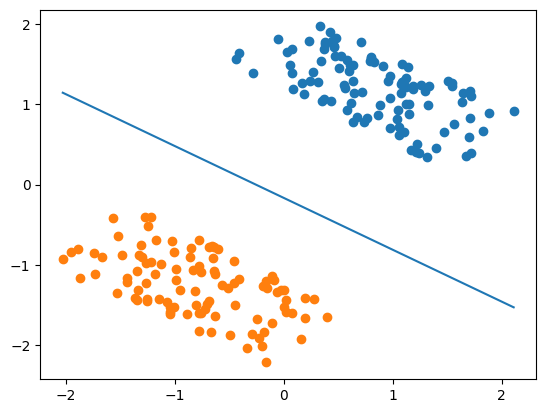

In [16]:
import matplotlib.pyplot as plt
category = {'+1': [], '-1': []}
for point, label in zip(x_data, y_data):
    if label == 1.0: category['+1'].append(point)
    else: category['-1'].append(point)
fig = plt.figure()
ax = fig.add_subplot(111)

# plot points
for label, pts in category.items():
    pts = np.array(pts)
    ax.scatter(pts[:, 0], pts[:, 1], label=label)

# calculate weight
weight = w
bias = b
# plot the model: wx+b
x1 = np.min(x_data[:, 0])
y1 = (-bias - weight[0] * x1) / weight[1]
x2 = np.max(x_data[:, 0])
y2 = (-bias - weight[0] * x2) / weight[1]
ax.plot([x1, x2], [y1, y2])

            
plt.show()

通过可视化，可以看到我们已经找到了一个分类边界。如果你多次运行上面的训练和可视化过程，可以发现由于**超参数**和**随机性**的存在，尽管理论上最优解存在，但SGD找到的结果并不总是最好的。因为我们希望，对于一组数据点，假设数据点到分类边界的距离的集合为$\{\gamma_1,\gamma_2,\gamma_3,\cdots, \gamma_N\}$，我们所期望的优化效果是
$$
    \boldsymbol{w}, b = \arg\max_{\boldsymbol{w}, b}\min\{\gamma_1,\gamma_2,\gamma_3,\cdots, \gamma_N\}
$$

而SVM的优化作为一个凸优化，显然有更好的算法来优化。

## 序列最小优化算法(Sequential Minimal Optimization)与核技巧(Kernel Trick)

SMO算法于1998由John Platt发明，点击可以查看原始论文

[Sequential Minimal Optimization:A Fast Algorithm for Training Support Vector Machines](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

这个算法的效率非常高

在课程中，我们已经介绍了我们可以用拉格朗日函数来求解SVM：

$$
\mathcal{L}(\boldsymbol{w},b,\boldsymbol{\alpha})=\frac{1}{2}||\boldsymbol{w}||^2 - \sum_{i=1}^{m}\alpha_i[y^{(i)}(\boldsymbol{w}^\top \boldsymbol{x}^{(i)}+b) - 1]
$$

这个函数依然是个凸函数，因此极值点梯度为0，我们对$\boldsymbol{w}, b$分别求梯度求解得到

$$
\frac{\partial \mathcal{L}(\boldsymbol{w},b,\boldsymbol{\alpha})}{\partial \boldsymbol{w}} = \boldsymbol{w}-\sum_{i=1}^{m}\alpha_i y^{(i)}\boldsymbol{x}^{(i)}=0 \Rightarrow \boldsymbol{w}=\sum_{i=1}^{m}\alpha_i y^{(i)}\boldsymbol{x}^{(i)} \\
\frac{\partial \mathcal{L}(\boldsymbol{w},b,\boldsymbol{\alpha})}{\partial b} = \sum_{i=1}^{y^{(i)}} \alpha_i y^{(i)}=0
$$

等量代换得到：

$$
\begin{aligned}
\mathcal{L}(\boldsymbol{w},b,\boldsymbol{\alpha}) & = \sum_{i=1}^{m} \alpha_i - \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \boldsymbol{x}^{(i)\top} \boldsymbol{x}^{(j)}.
\end{aligned}
$$

由于**强对偶**性，我们把问题转化为
$$
\begin{aligned}
\max_{\boldsymbol{\alpha}: \alpha_i \ge 0} \mathcal{L}(\boldsymbol{w},b,\boldsymbol{\alpha}) = \max_{\boldsymbol{\alpha}: \alpha_i \ge 0} \sum_{i=1}^{m} \alpha_i - \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \boldsymbol{x}^{(i)\top} \boldsymbol{x}^{(j)} \\
= \min_{\alpha: \alpha_i \ge 0} \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \boldsymbol{x}^{(i)\top} \boldsymbol{x}^{(j)} - \sum_{i=1}^{m} \alpha_i \\
\mathcal{s.t.} \qquad \sum_{i=1}^{y^{(i)}} \alpha_i y^{(i)}=0 \quad \mathrm{and} \quad \alpha_i \ge 0
\end{aligned}
$$

对于**线性不可分**的情况

$$
\min_{\boldsymbol{\alpha}: \alpha_i \ge 0} \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \boldsymbol{x}^{(i)\top} \boldsymbol{x}^{(j)} - \sum_{i=1}^{m} \alpha_i \\
\mathcal{s.t.} \qquad \sum_{i=1}^{m} \alpha_i y^{(i)}=0 \quad \mathrm{and} \quad 0 \le \alpha_i \le C
$$

关于强对偶性以及线性不可分的证明可以参考 **课上内容** 或者 吴恩达的笔记 [Support Vector Machine](http://cs229.stanford.edu/notes/cs229-notes3.pdf)(也可以去网上自行寻找吴恩达的笔记，这个老的链接好像打不开了)，这里不再详细说明



于是我们就可以通过SMO算法来求解SVM优化问题，可能课上讲的不够详细，这里给出更具体的参考

[Stanford CS229 2009 SMO](http://cs229.stanford.edu/materials/smo.pdf)

也可以把原始论文作为参考，下面请实现SMO算法

In [17]:
def default_kernel(x, z):
    return x.dot(z.T)

def svm_smo(X_in, y_in, C, max_iter, epsilon=1e-5, kernel=default_kernel):
    """
    Inputs have dimension D, we operate on minibatches of N examples.
    - X_in: A numpy array of shape (N, D) containing a minibatch of data.
    - y_in: A numpy array of shape (N,) containing training labels; y[i] = -1/1 means that X[i] has label -1/1
    - kernel: kernel function, using inner product by default
    - C: relax factor
    - max_iter: max iteration
    - epsilon: numerical tolerance

    Returns a tuple of:
    - alpha: Described as above, a np array of shape (N, )
    - b: the bias
    """
    n, _ = X_in.shape
    alpha = np.zeros((n,))
    b = 0
    
    #############################################################################
    # TODO:                                                                     #
    # Implement SMO Algorithm                                                   #
    #############################################################################

    def K(i, j):
        return kernel(X_in[i], X_in[j])
    
    for l in range(max_iter):
        for i in range(n):
            Ei = np.sum(alpha * y_in * K(i, np.arange(n))) + b - y_in[i]
            if (y_in[i] * Ei < -epsilon and alpha[i] < C) or (y_in[i] * Ei > epsilon and alpha[i] > 0):
                j = np.random.choice(np.delete(np.arange(n), i))
                Ej = np.sum(alpha * y_in * K(j, np.arange(n))) + b - y_in[j]
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                if y_in[i] != y_in[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])
                if L == H:
                    continue
                eta = 2 * K(i, j) - K(i, i) - K(j, j)
                if eta >= 0:
                    continue
                alpha[j] = alpha[j] - y_in[j] * (Ei - Ej) / eta
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)
                if abs(alpha[j] - alpha_j_old) < epsilon:
                    continue
                alpha[i] = alpha[i] + y_in[i] * y_in[j] * (alpha_j_old - alpha[j])
                b1 = b - Ei - y_in[i] * (alpha[i] - alpha_i_old) * K(i, i) - y_in[j] * (alpha[j] - alpha_j_old) * K(i, j)
                b2 = b - Ej - y_in[i] * (alpha[i] - alpha_i_old) * K(i, j) - y_in[j] * (alpha[j] - alpha_j_old) * K(j, j)
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2


    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    
    return alpha, b

至此你已经完成了SMO算法，下面的代码会用于测试你的代码

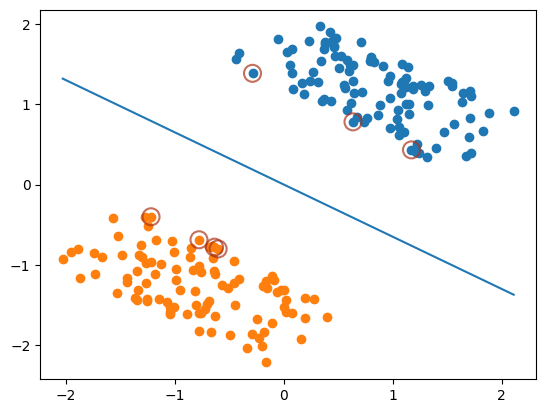

In [18]:
def plot_result(x, y, alpha, bias):
    category = {'+1': [], '-1': []}
    for point, label in zip(x, y):
        if label == 1.0: category['+1'].append(point)
        else: category['-1'].append(point)
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot points
    for label, pts in category.items():
        pts = np.array(pts)
        ax.scatter(pts[:, 0], pts[:, 1], label=label)

    # calculate weight
    weight = 0
    for i in range(alpha.shape[0]):
        weight += alpha[i] * y[i] * x[i]

    # plot the model: wx+b
    x1 = np.min(x[:, 0])
    y1 = (-bias - weight[0] * x1) / weight[1]
    x2 = np.max(x[:, 0])
    y2 = (-bias - weight[0] * x2) / weight[1]
    ax.plot([x1, x2], [y1, y2])

    # plot the support vectors
    for i, alpha_i in enumerate(alpha):
        if abs(alpha_i) > 1e-3: 
            ax.scatter([x[i, 0]], [x[i, 1]], s=150, c='none', alpha=0.7,
                       linewidth=1.5, edgecolor='#AB3319')

    plt.show()

alpha, bias = svm_smo(x_data, y_data, 1e10, 1000)

plot_result(x_data, y_data, alpha, bias)

如果一切正常，你会看到一条优秀的分界线，圈出的数据点代表了 **支持向量**，支持向量决定了分界面的位置，直接表现是对应的数据点约束条件的 **拉格朗日乘子系数较大**

至此，我们已经对线性SVM以及其优化有了全面的了解，下面我们引入 **核函数** 的概念

并不是所有的数据都是平面可以分割的，比如下面的数据

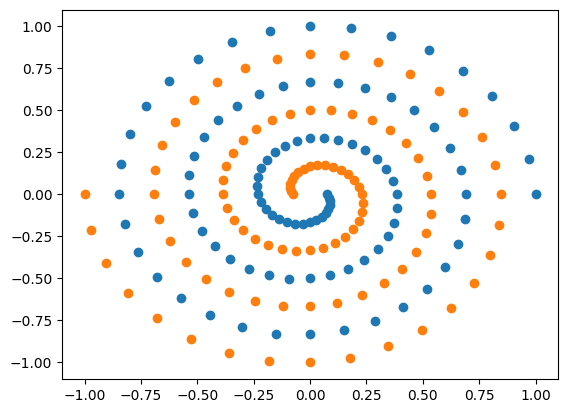

In [19]:
data = np.loadtxt('./dataset/Assignment2/data.txt')
x_sp = data[:,:2]
y_sp = data[:,2]
data_visualization(x_sp, y_sp)

显而易见，上面的数据很难用一个平面进行划分，但是我们发现，如果我们将数据点映射到高维空间，事情就会发生变化，但是这种映射难以找到，下面给出一个映射的例子，这个映射不能分割数据，大家可以自行尝试其他的映射方式，此部分不计分，如果能够在三维空间中使得数据线性可分，则可以获得额外分。
$$
\phi(\boldsymbol{x}) = \begin{bmatrix}
x_1^2\\
x_2^2\\
x_1 + x_2\\
\end{bmatrix}
$$

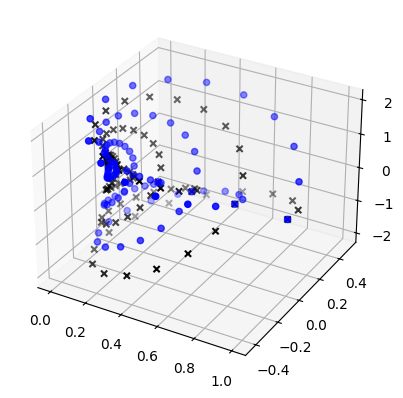

In [20]:
from mpl_toolkits.mplot3d import Axes3D
x_sp_p = np.concatenate([x_sp[:, :1] * x_sp[:, :1], 
                         x_sp[:, :1] * x_sp[:, 1:], 
                         x_sp[:, 1:] + x_sp[:, 1:]], axis=-1)
# you can try to modify x_sp_p
data_visualization(x_sp_p, y_sp, 3)

我们已经知道了线性SVM的优化问题：
$$
\min_{\boldsymbol{\alpha}: \alpha_i \ge 0} \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \boldsymbol{x}^{(i)\top} \boldsymbol{x}^{(j)} - \sum_{i=1}^{m} \alpha_i \\
\mathcal{s.t.} \qquad \sum_{i=1}^{m} \alpha_i y^{(i)}=0 \quad \mathrm{and} \quad 0 \le \alpha_i \le C
$$

如果要引入到高维空间的映射，问题变为：

$$
\min_{\boldsymbol{\alpha}: \alpha_i \ge 0} \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \color{red}{\phi(\boldsymbol{x}^{(i)})^{\top} \phi(\boldsymbol{x}^{(j)})} - \sum_{i=1}^{m} \alpha_i \\
 =  \min_{\boldsymbol{\alpha}: \alpha_i \ge 0} \frac{1}{2}\sum_{i=1}^{m} \sum_{j=1}^{m} y^{(i)} y^{(j)} \alpha_i \alpha_j \color{red}{K(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)})} - \sum_{i=1}^{m} \alpha_i \\
\mathcal{s.t.} \qquad \sum_{i=1}^{m} \alpha_i y^{(i)}=0 \quad \mathrm{and} \quad 0 \le \alpha_i \le C
$$

我们不需要去找到复杂的$\phi$映射，因为在SVM的优化问题中，我们只需要计算内积，因此，我们只需要找到一个核函数
$$
K(\boldsymbol{x}, \boldsymbol{z}) = \phi(\boldsymbol{x})^{\top}\phi(\boldsymbol{z})
$$


$\phi$是复杂的，但是核函数是相对容易的，我们给出四种核函数：

- 指数核: $\exp\left(-\frac{\|\boldsymbol{x}-\boldsymbol{z}\|}{2\sigma^2}\right)$

- 多项式核: $\left(\boldsymbol{x}^\top\boldsymbol{z}\right)^d$

- 余弦相似度核: $\frac{\boldsymbol{x}^\top\boldsymbol{z}}{\|\boldsymbol{x}\|\cdot\|\boldsymbol{z}\|}$

- sigmoid核: $\tanh(\alpha\boldsymbol{x}^\top\boldsymbol{z} + c)$

现在请实现这些其中常用的指数，多项式，余弦相似度核函数

In [21]:
def poly_ker_wrap(d):
    """
    polynomial kernel
    - d: degree
    Returns:
    - ker: the kernel function
    """
    #############################################################################
    # TODO:                                                                     #
    # Implement polynomial kernel                                               #
    #############################################################################
    
    ker = lambda x, z: (1 + x.dot(z.T)) ** d
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return ker
    
def cos_ker_wrap():
    """
    cosine similarity kernel
    Returns:
    - ker: the kernel function
    """
    #############################################################################
    # TODO:                                                                     #
    # Implement cosine similarity kernel                                        #
    #############################################################################
    
    ker = lambda x, z: x.dot(z.T) / (np.linalg.norm(x) * np.linalg.norm(z))

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return ker
    
def exp_ker_wrap(sigma):
    """
    RBF kernel
    - sigma: variance
    Returns:
    - ker: the kernel function
    """
    #############################################################################
    # TODO:                                                                     #
    # Implement RBF kernel                                                      #
    #############################################################################
    
    ker = lambda x, z: np.exp(-np.linalg.norm(x - z) / (2 * sigma ** 2))
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return ker

对于上面这个线性不可分的数据，指数核可以起到非常好的效果，运行下面的代码进行比较，你可能需要调整训练轮数来得到比较好的效果。

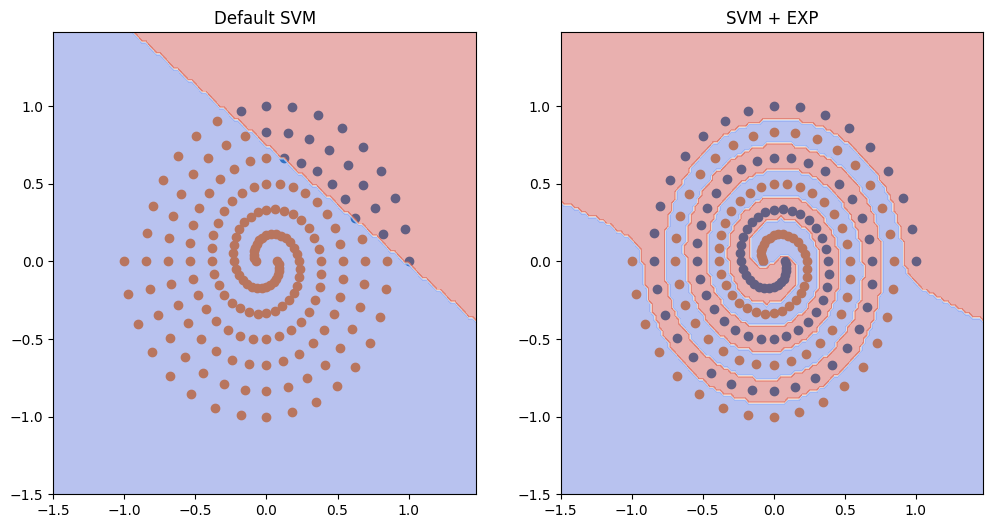

In [22]:
from matplotlib import cm
def plot_boundary(ax, model, x, title):
    y = model(x)
    y[y < 0], y[y >= 0] = -1, 1

    category = {'+1': [], '-1': []}
    for point, label in zip(x, y):
        if label == 1.0: category['+1'].append(point)
        else: category['-1'].append(point)
    for label, pts in category.items():
        pts = np.array(pts)
        ax.scatter(pts[:, 0], pts[:, 1], label=label)
    
    # plot boundary
    p = np.meshgrid(np.arange(-1.5, 1.5, 0.025), np.arange(-1.5, 1.5, 0.025))
    x = np.array([p[0].flatten(), p[1].flatten()]).T
    y = model(x)
    y[y < 0], y[y >= 0] = -1, 1
    y = np.reshape(y, p[0].shape)
    ax.contourf(p[0], p[1], y, cmap=plt.cm.coolwarm, alpha=0.4)
    
    # set title
    ax.set_title(title)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

def get_model(x_data_used, y_data_used, alpha, b, kernel):
    def model(X_in):
        results = []
        for k in range(X_in.shape[0]):
            result = b
            for i in range(x_data_used.shape[0]):
                result += y_data_used[i] * alpha[i] * kernel(x_data_used[i], X_in[k])
            results.append(result)
        return np.array(results)
    return model


# modify the max iteration and numerical tolerance to achieve better performance
alpha, b = svm_smo(x_sp, y_sp, 1e10, 100, 1e-4, default_kernel)
model = get_model(x_sp, y_sp, alpha, b, default_kernel)
plot_boundary(ax1, model, x_sp, 'Default SVM')

ker = exp_ker_wrap(0.2)

alpha, b = svm_smo(x_sp, y_sp, 1e10, 800, 1e-6, ker)
model = get_model(x_sp, y_sp, alpha, b, ker)
plot_boundary(ax2, model, x_sp, 'SVM + EXP')

plt.show()